In [1]:
import sys
sys.path.append("..")

import numpy as np
import pandas as pd

# Helper classes for data processing, state representation
from reinforcetrader.data_pipeline import RawDataLoader, FeatureBuilder
from reinforcetrader.state import EpisodeStateLoader
from reinforcetrader.dqn_agent import DRLAgent

# Helper method for displaying large dataframes
from IPython.display import HTML
pd.set_option("display.max_rows", None)
from IPython.display import HTML, display

def display_df(df, rows=10):
    # Puts the scrollbar next to the DataFrame
    display(HTML("<div style='height: 300px; overflow: auto; width: 98%'>" + df.head(rows).to_html() + "</div>"))

# Data Pre-processing and Feature Building
The `RawDataLoader` class downloads OHLCV data for all tickers in a specified index (if the `index` argument is provided). Otherwise, it expects a list of tickers for which the data will be downloaded.

It implements a caching feature for index data: if data for the requested date range already exists locally, it is loaded to minimize API calls. If not, the data is downloaded from Yahoo Finance and saved for future retrieval.

When an index is provided, the `get_hist_prices()` method returns both the ticker data and the benchmark index OHLCV data.

In [2]:
# Get DJI raw data using Yahoo Finance API
data_loader = RawDataLoader(start_date='1999-08-01', end_date='2025-09-08', index='DJI', verbose=False)

# Download or load the data from cache
ticker_data, benchmark_data = data_loader.get_hist_prices()

# Inspect the raw DJI tickers OHLCV data
display_df(ticker_data)

Ticker,AAPL,AMGN,AMZN,AXP,BA,CAT,CSCO,CVX,DIS,GS,HD,HON,IBM,JNJ,JPM,KO,MCD,MMM,MRK,MSFT,NKE,NVDA,PG,SHW,TRV,UNH,VZ,WMT,AAPL,AMGN,AMZN,AXP,BA,CAT,CSCO,CVX,DIS,GS,HD,HON,IBM,JNJ,JPM,KO,MCD,MMM,MRK,MSFT,NKE,NVDA,PG,SHW,TRV,UNH,VZ,WMT,AAPL,AMGN,AMZN,AXP,BA,CAT,CSCO,CVX,DIS,GS,HD,HON,IBM,JNJ,JPM,KO,MCD,MMM,MRK,MSFT,NKE,NVDA,PG,SHW,TRV,UNH,VZ,WMT,AAPL,AMGN,AMZN,AXP,BA,CAT,CSCO,CVX,DIS,GS,HD,HON,IBM,JNJ,JPM,KO,MCD,MMM,MRK,MSFT,NKE,NVDA,PG,SHW,TRV,UNH,VZ,WMT,AAPL,AMGN,AMZN,AXP,BA,CAT,CSCO,CVX,DIS,GS,HD,HON,IBM,JNJ,JPM,KO,MCD,MMM,MRK,MSFT,NKE,NVDA,PG,SHW,TRV,UNH,VZ,WMT
Price,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1999-08-02,0.418000,26.817356,2.350000,26.692303,29.387831,15.052662,20.104939,17.092596,20.332203,43.463631,24.154650,32.096699,60.367683,23.210752,24.574461,14.428640,22.649607,18.075357,24.918245,25.904121,4.645388,0.038799,22.648542,6.074229,16.676920,5.997555,16.792963,8.996620,0.434870,27.243028,2.553125,27.859530,29.828849,15.149050,20.816438,17.338448,20.846351,44.674558,24.856540,32.377156,62.219455,23.463215,24.652972,14.698896,22.682720,18.278024,25.403667,26.553156,4.853909,0.038918,22.931257,6.143888,16.935979,6.136893,16.922140,9.235469,0.416126,26.093713,2.348438,26.640997,28.866628,15.004468,19.921982,17.034060,20.332203,43.160899,24.009431,32.003215,60.151644,23.100300,24.123012,14.413626,21.954224,17.657358,24.825785,25.770497,4.610634,0.038202,22.570011,6.018502,16.223567,5.912741,16.534610,8.917004,0.417063,26.093713,2.459375,27.089928,29.107183,15.068727,20.064281,17.104303,20.612647,44.458321,24.445086,32.190185,61.231844,23.210752,24.162270,14.548754,21.987338,17.822024,24.872014,26.171371,4.807571,0.038440,22.570011,6.018502,16.320714,5.912741,16.599198,8.983351,362443200,14186400,339356000,8751857,2641100,2118000,28405600,1705000,3526812,566400,4064100,1216283,4775095,3559800,6278850,5161000,2372700,2258287,3458295,48050600,14422400,313344000,4158800,581400,377100,3470400,3194070,16741800
1999-08-03,0.414252,26.093704,2.371875,25.999659,30.189690,14.875947,19.881329,17.420399,20.051756,42.079704,23.476974,31.691586,58.948006,23.778803,24.751123,14.608812,22.450933,18.265354,24.779543,25.885025,4.564300,0.037843,23.543795,6.032433,16.644554,5.555311,16.534613,8.903736,0.430653,26.966332,2.425000,26.987314,30.189690,15.149048,20.348885,17.432106,20.519164,43.463621,24.299877,32.314822,60.799778,23.983929,24.790379,14.683883,22.682728,18.316021,25.195616,26.285899,4.784405,0.038799,23.685152,6.088160,16.838849,5.815811,16.889848,9.102776,0.402068,25.604181,2.240625,25.858566,29.508116,14.763494,19.596729,17.069181,19.771311,42.036457,23.428567,31.473452,58.361612,23.494783,24.495957,14.443656,22.152912,18.100686,24.640852,25.770490,4.558508,0.037485,22.695653,5.976706,16.482642,5.537136,16.486172,8.771042,0.425498,26.881198,2.425000,26.833393,29.508116,15.052659,20.328557,17.373570,20.332200,43.463621,24.106253,32.096688,60.614599,23.699908,24.574470,14.443656,22.517160,18.214687,25.080040,26.228632,4.738067,0.038799,22.711359,6.046365,16.612172,5.815811,16.760672,9.036429,368379200,11616400,582780000,8694619,2854000,2275600,32937000,2072200,7458388,837700,585

The `FeatureBuilder` class computes features required for the Deep Q-Network (DQN) as well as features used in reward functions (e.g., look-ahead excess returns). The `get_feature_indices()` method returns index lists for OHLCV, reward-related, and DQN input features to prevent cross-contamination and look-ahead bias.  

Currently, the `FeatureBuilder` performs the following:  
- Builds features for each ticker, including inputs for the CNN branch and the technical indicators branch used in the DQN.  
- Saves computed features to a CSV file for optional separate analysis.  
- Returns separate index lists for reward function features, backtesting features (OHLCV), and RL state representation features to avoid look-ahead bias.  
- Implements the following features:  
  - **OHLCV**: Open, High, Low, Close, Volume  
  - **Reward Function**: Excess returns relative to the benchmark on user-specified horizons  
  - **State Representation**:  
    - Body/HL: Ratio of candlestick body length to daily high–low range  
    - UWick/HL: Ratio of upper wick to daily high–low range  
    - LWick/HL: Ratio of lower wick to daily high–low range  
    - Gap: Standardized log gap ($\ln \frac{open}{previous \space close}$)
    - Gap Fill: Percentage of gap filled after a gap up or gap down  
    - EMA Ratios: Standardized ratios EMA5/13, EMA13/26, EMA26/50  
    - Bollinger Bands: B%B (position of close relative to bands; upper=1, mid=0.5, lower=0) and standardized BBW  
    - RSI: Standardized Relative Strength Index  
    - ADX: Scaled Average Directional Index in [0, 1]  
    - Vol/Vol20: Standardized ratio of volume to 20-day average volume

In [3]:
# Instantiate Feature Builder to Build relevant features for state space
feature_builder = FeatureBuilder(ticker_data=ticker_data, benchmark_data=benchmark_data, f_prefix='DJI')

# Build the features
feature_builder.build_features()

# Store the computed features and the feature index ranges (used later)
features_data = feature_builder.get_features()
feature_indices = feature_builder.get_feature_indices()

# Inspect the features
display_df(features_data.head(), rows=20)

Building ticker features: 100%|█████████████████████████████████████| 28/28 [00:04<00:00,  6.09it/s]


File already exists, skipping save: ../data/processed/DJI_tickers_features_2000-04-07_2025-09-04.csv


# Episode Data Representation

In [4]:
# Define the Walk-Forward Validation configuration
WFV_config = {
    'mode': 'expanding', # supports 'expanding' and 'moving'
    'train_start': '2000-04-07',
    'train_end': '2019-09-30',
    'test_start': '2019-10-01',
    'test_end': '2025-07-31',
    'train_window_size': 1200,
    'val_window_size': 630
}

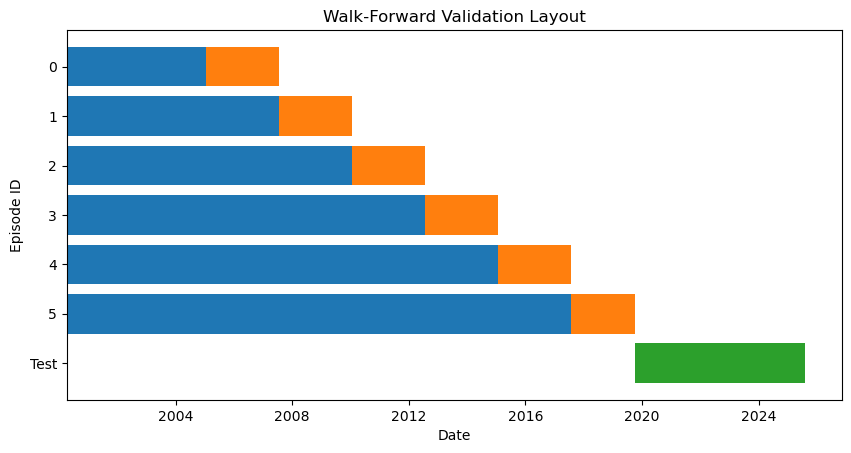

In [5]:
# Initialize the episode state loader
state_loader = EpisodeStateLoader(features_data, feature_indices, WFV_config)

# Plot the episode configurations
state_loader.get_WFV_plot()

In [6]:
# State matrix is derived through state loader by providing ticker/eipsode details and window size
state_loader.get_state_matrix('validate', 1, 'AAPL', 2, 4)

array([[ 0.5023908 ,  0.10286992,  0.39473928,  0.94032509,  1.        ,
         1.37197295,  1.34763108,  1.52557152,  0.94597025,  1.52933991,
         1.34085729,  0.36767679,  0.64892816],
       [ 0.09091079,  0.35431275,  0.55477647, -0.68005594,  1.        ,
         1.35822345,  1.38924301,  1.55015523,  0.89252075,  1.6733794 ,
         1.3069305 ,  0.38244313,  0.21502136],
       [-0.5824806 ,  0.30948789,  0.10803151, -3.87205332,  0.43983256,
         0.49239547,  1.13292489,  1.45067204,  0.59270299,  1.52898711,
        -0.43631097,  0.37010664,  2.07364735],
       [-0.02678227,  0.30060121,  0.67261652,  1.56562327,  0.95529579,
         0.1329012 ,  0.9762791 ,  1.38264424,  0.65213279,  1.25991759,
        -0.18347184,  0.35865133,  1.23746504]])

In [7]:
# Similarly, ticker OHLCV data is drived
state_loader.get_state_OHLCV('train', 1, 'AAPL', 1)

{'Open': 0.9873609353232202,
 'High': 0.9953276617593186,
 'Low': 0.9353452181062036,
 'Close': 0.937219500541687,
 'Volume': 212262400.0}

In [8]:
# Reward computes returned seperatly to explicitly avoid look-ahea bias
state_loader.get_reward_computes('train', 1, 'AAPL', 1)

{'1DFRet': -0.04449942361752468}

# Deep Q-Network and RL Agent

In [9]:
# Create RL agent and DQN Model configuration
agent_config = {
    'num_features': len(feature_indices['State']),
    'learning_rate': 1e-3,
    'dropout_p': 0.1,
    'memory_buffer_len': 200000,
    'state_matrix_window': 60,
    'epsilon_start': 0.8,
    'epsilon_min': 0.05,
    'epsilon_boost_factor': 0.25,
    'decay_updates': 70000,
    'discount_factor': 0.95,
    'batch_size': 256,
    'replay_start_size': 5000,
    'train_interval': 1,
}

I0000 00:00:1766695123.927109  116156 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3584 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Loading model from ../model_checkpoints/DDQN_DSRC_AE1.keras


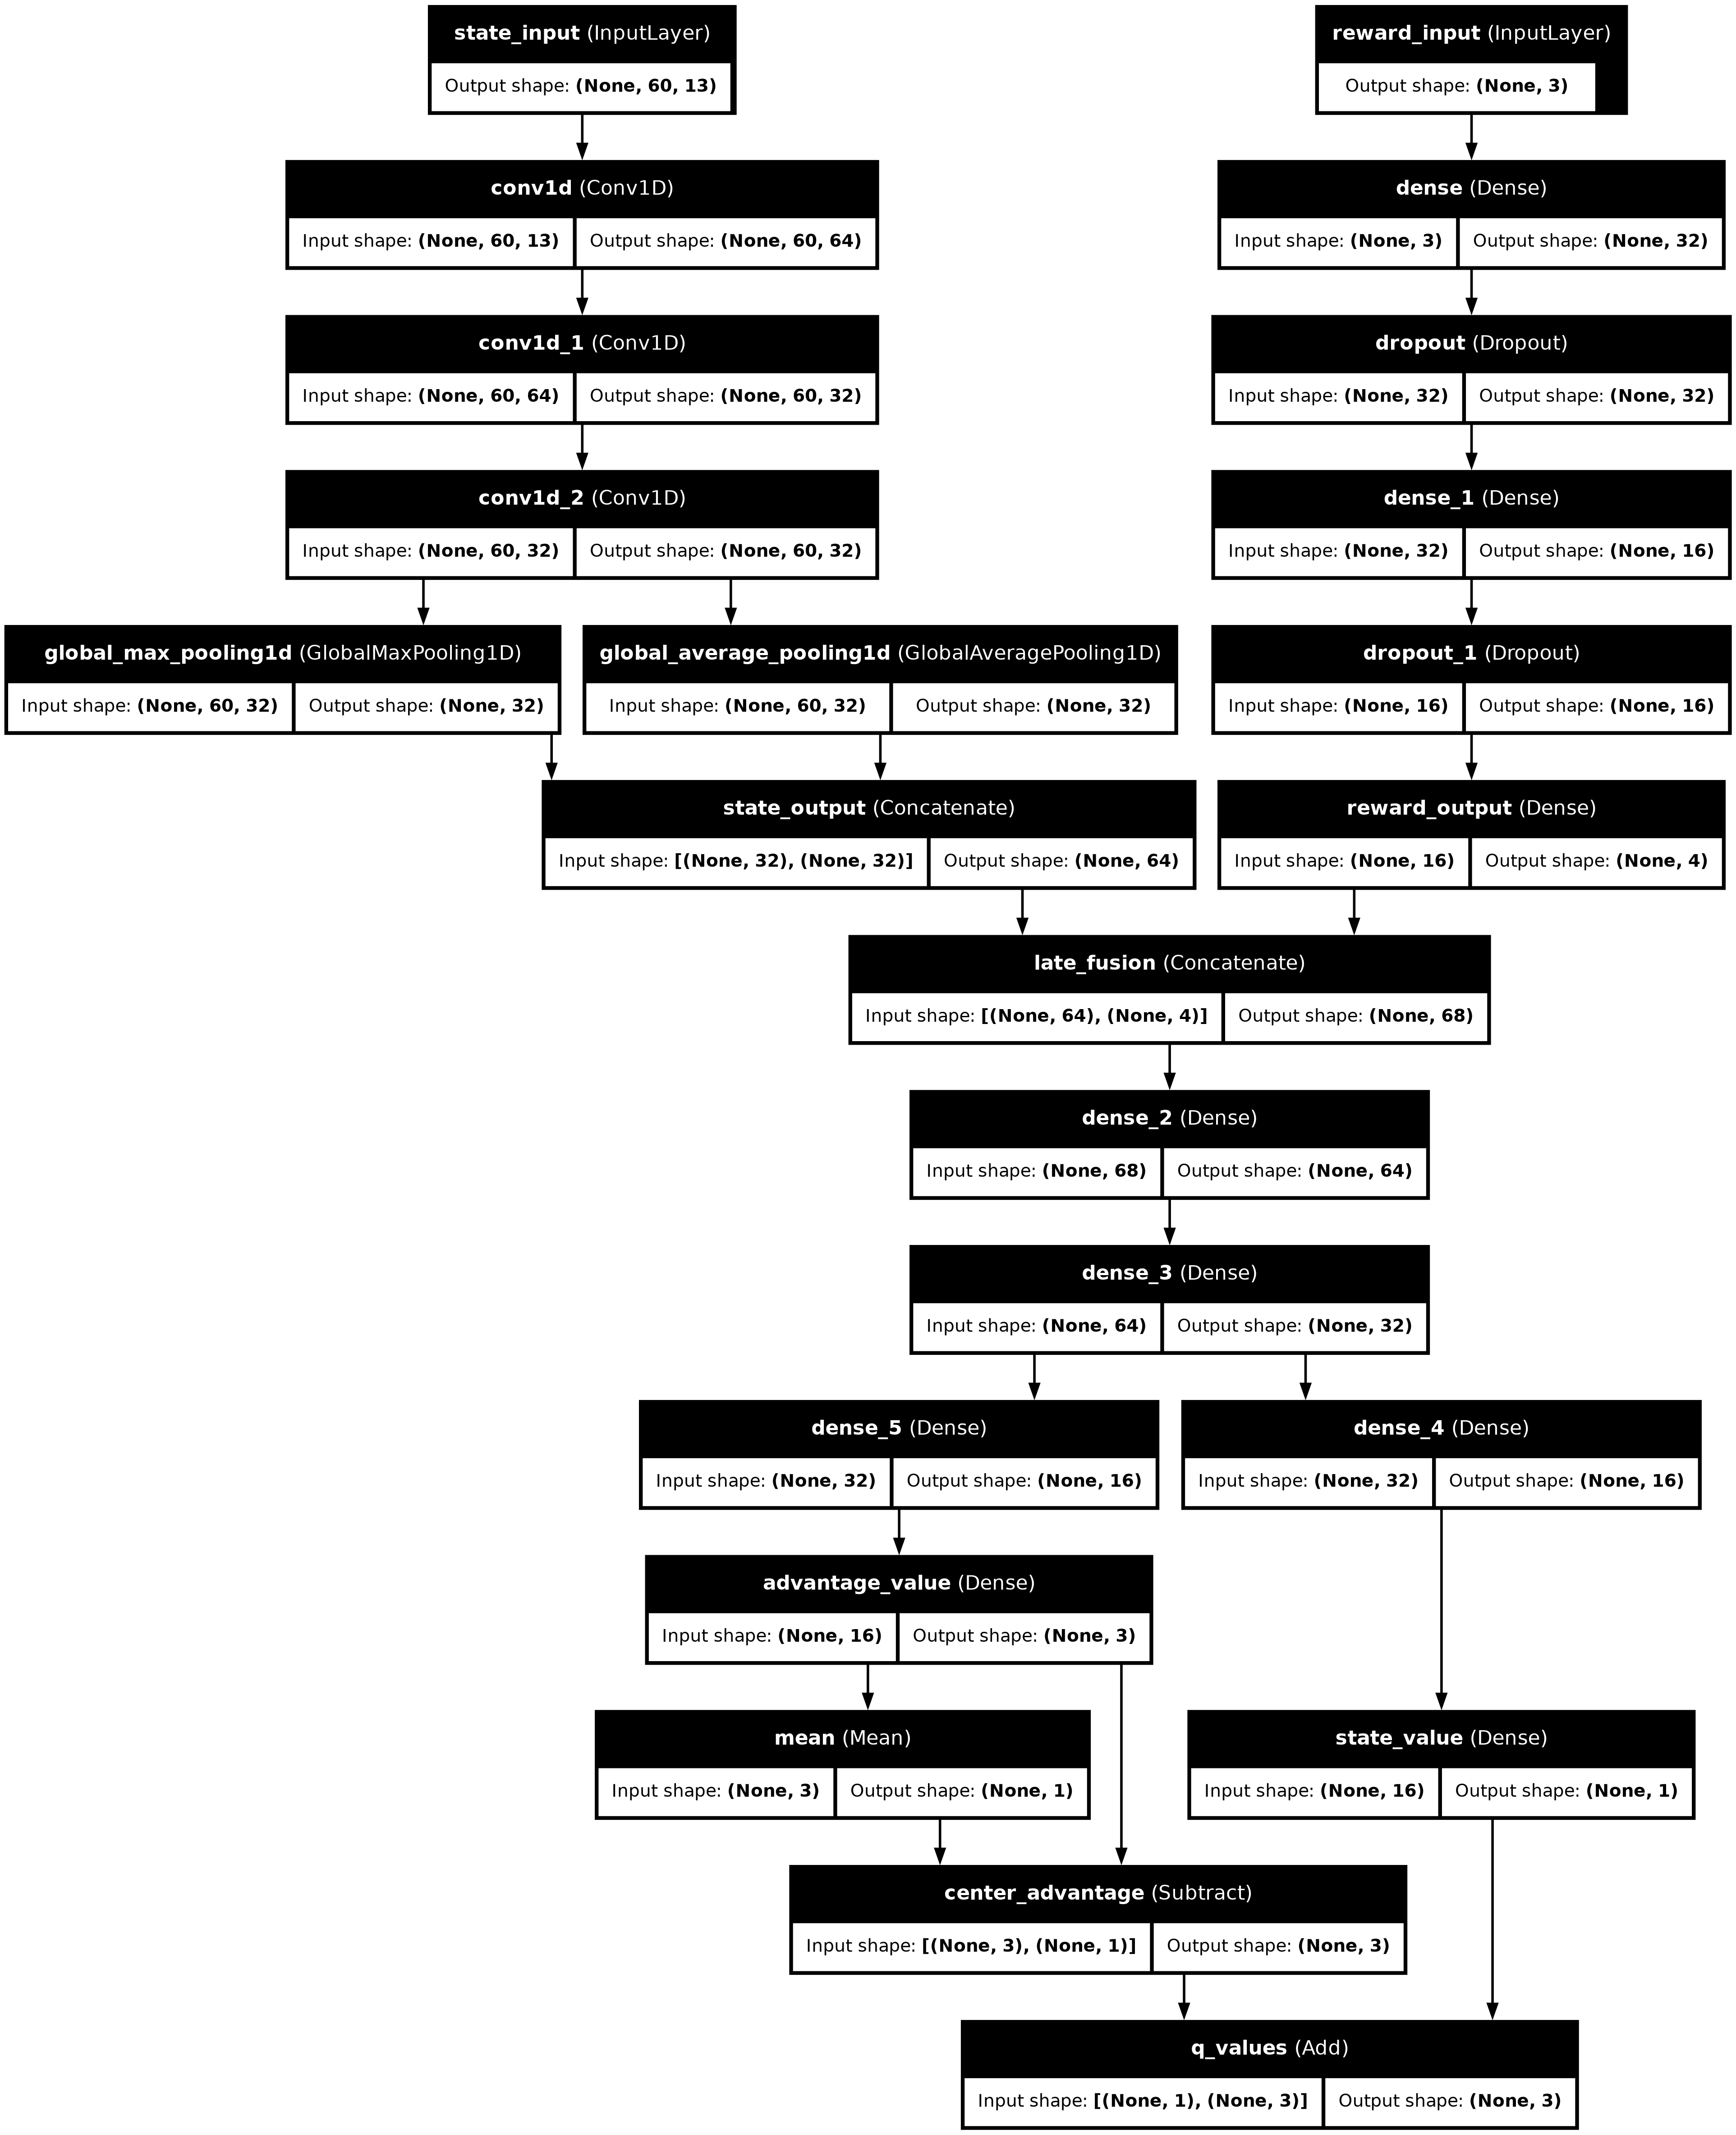

In [10]:
# Intialize the model with it's configuration
MODEL_PATH = '../model_checkpoints/DDQN_DSRC_AE1.keras'
agent = DRLAgent(agent_config=agent_config, reward_type='DSR', model_path=MODEL_PATH)

# Visualize the DQN architecture
agent.plot_model_arch(fname='../figures/DQN_arch.png')

# Train Agent

In [11]:
# Define directories for saving the model data
training_config = {
    'model_dir': '../model_checkpoints/',
    'plots_dir': '../plots/',
    'logs_dir': '../logs/'
}

Training episode 0: 100%|████████████████████████████████████████| 28/28 [5:35:32<00:00, 719.03s/it]


Removed 33374 outliers from histogram.


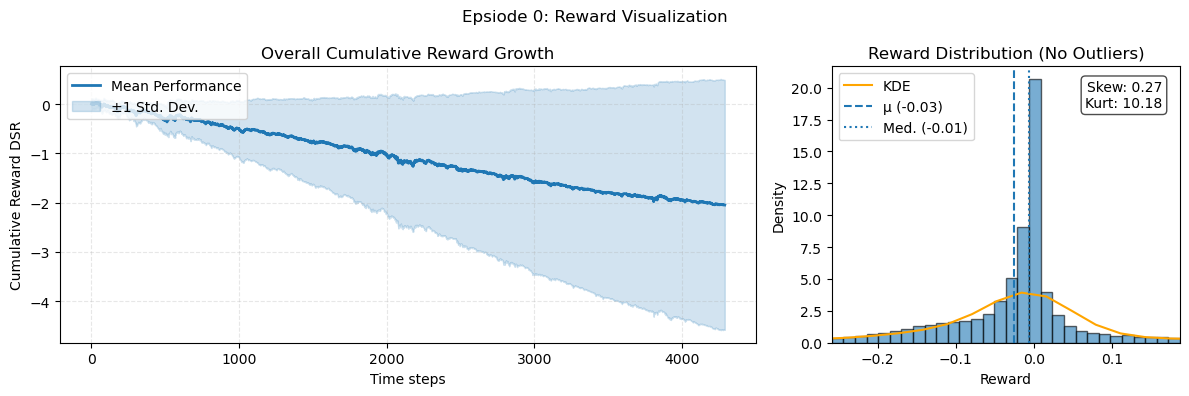

Episode 0 validation summary:
Train loss: 3673.3938, Val loss: 463.1701, Total val trades: 71, Hit rate: 0.56
Trade Duration: 63.18, Total PnL: 143.21, Profit Factor: 2.313
Force End Trade Count: 16, Force End PnL: 108.92


Training episode 1: 100%|████████████████████████████████████████| 28/28 [6:55:57<00:00, 891.33s/it]


Removed 37199 outliers from histogram.


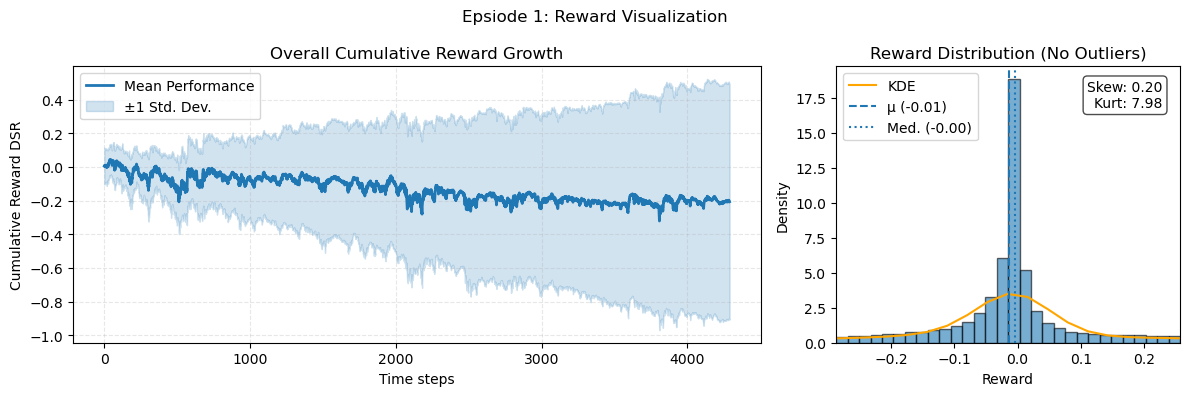

Episode 1 validation summary:
Train loss: 3938.0418, Val loss: 482.6338, Total val trades: 90, Hit rate: 0.72
Trade Duration: 79.34, Total PnL: 350.54, Profit Factor: 3.031
Force End Trade Count: 14, Force End PnL: 60.37


Training episode 2: 100%|████████████████████████████████████████| 28/28 [4:31:33<00:00, 581.91s/it]


Removed 39856 outliers from histogram.


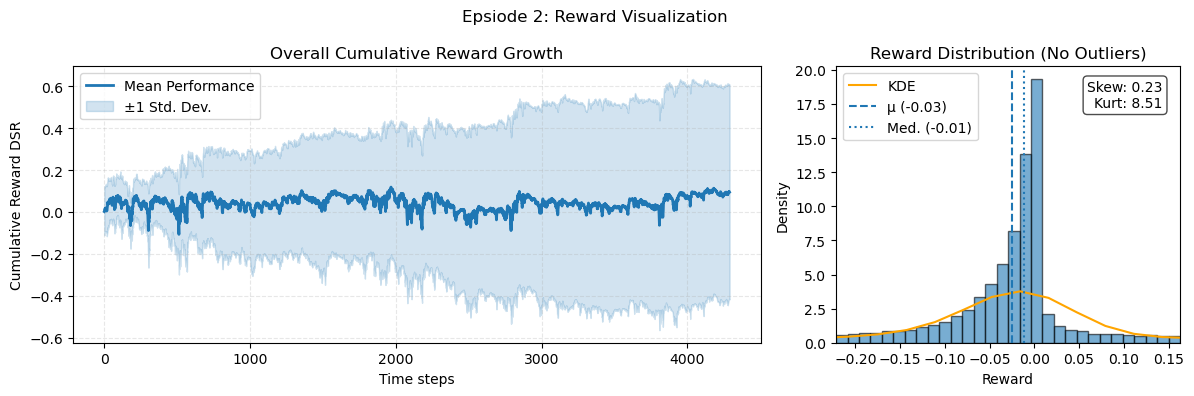

Training episode 3: 100%|████████████████████████████████████████| 28/28 [4:27:52<00:00, 574.03s/it]


Removed 37984 outliers from histogram.


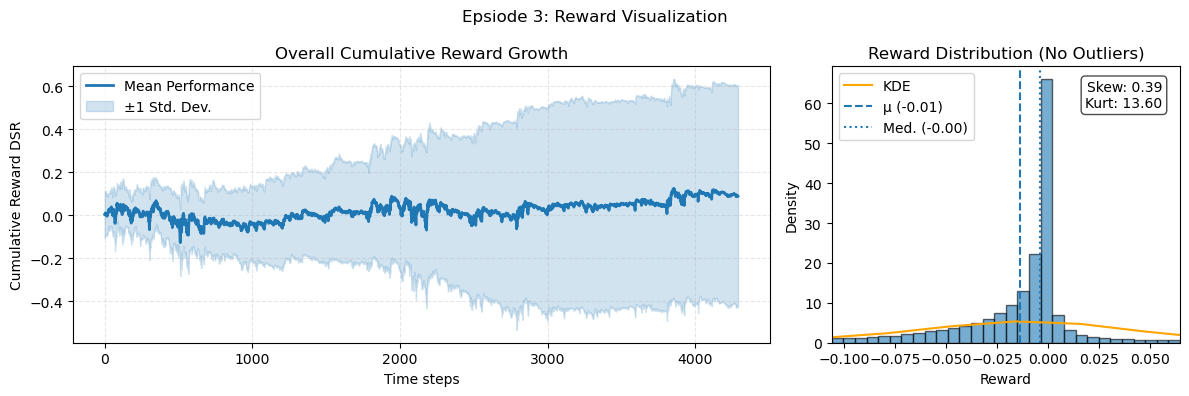

Episode 3 validation summary:
Train loss: 3667.4933, Val loss: 458.3948, Total val trades: 254, Hit rate: 0.70
Trade Duration: 23.02, Total PnL: 358.99, Profit Factor: 1.903
Force End Trade Count: 11, Force End PnL: -23.99


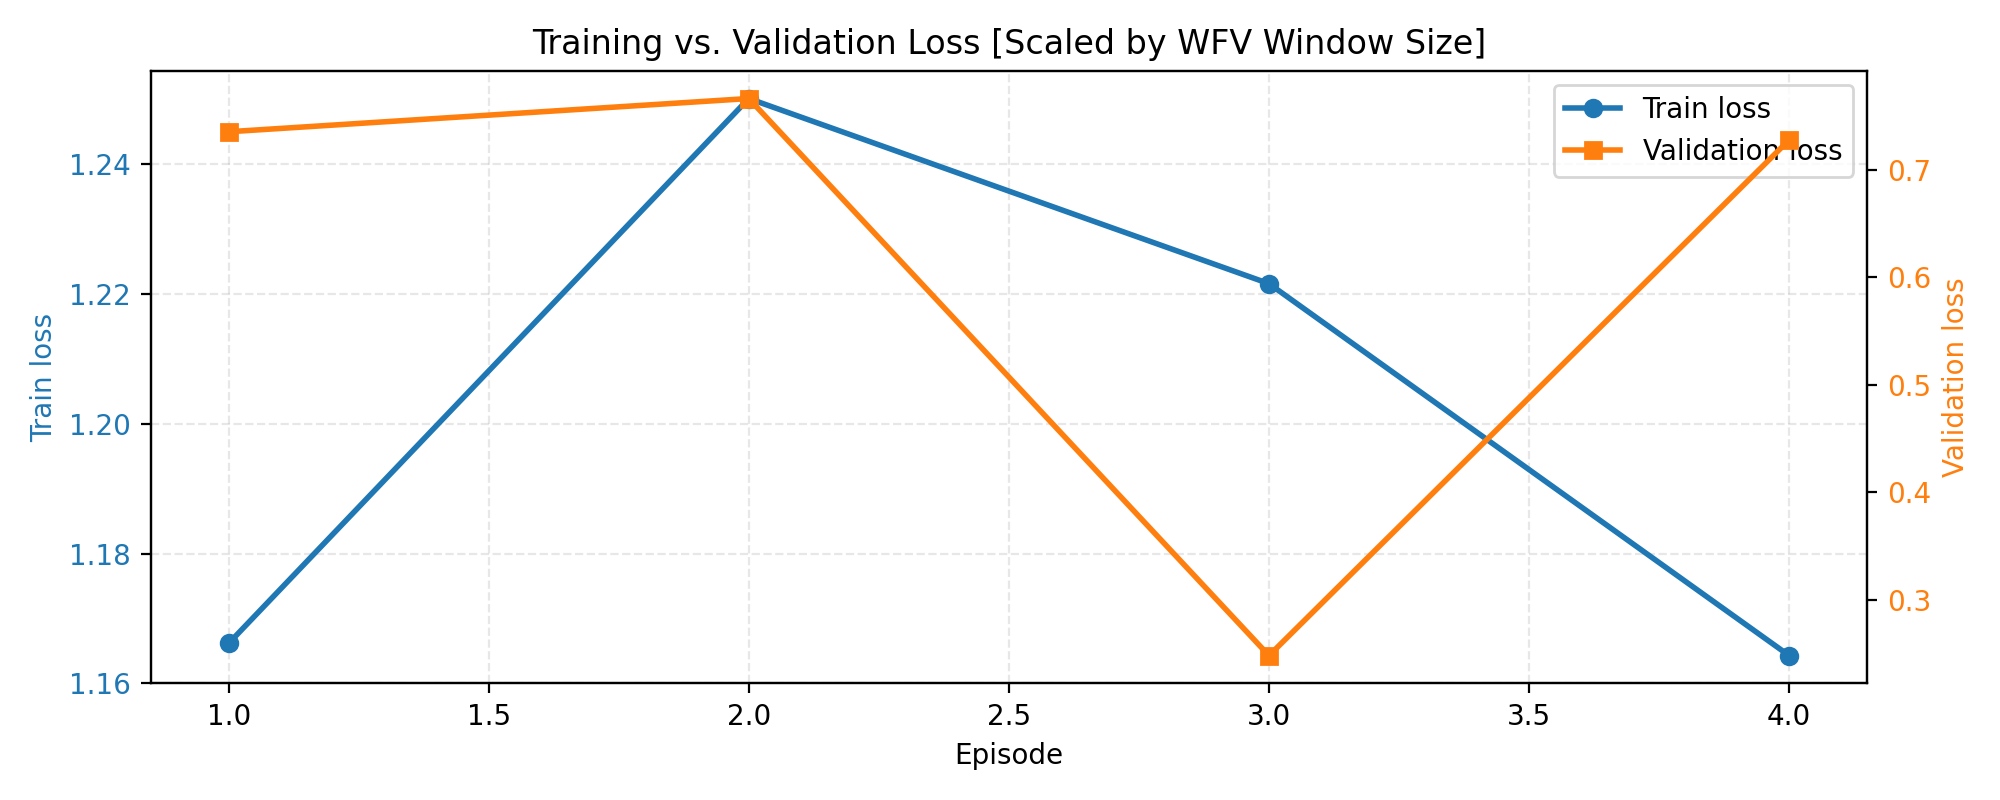

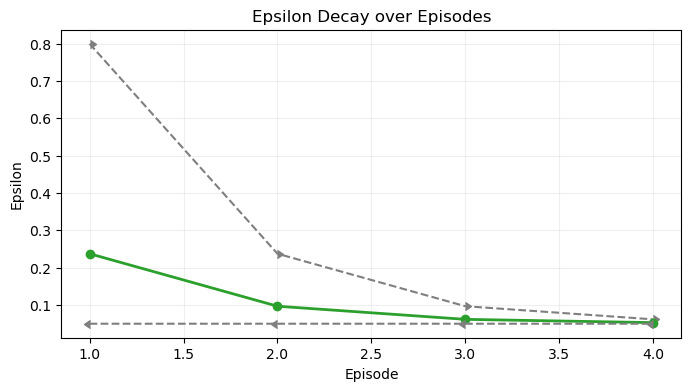

In [12]:
# Train the model with the set episodes
WFV_EPISODES = [5, 5, 5, 5]
agent.train(state_loader, WFV_EPISODES, training_config)